In [22]:
msv = 2151264647%3+1
print(msv)

3


In [35]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [36]:
df = pd.read_csv("data-kiem-tra-2.csv",encoding='ISO-8859-1')
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,10.05.2013,4,58,3773,299.0,1
1,26.05.2013,4,58,3768,249.0,1
2,19.05.2013,4,58,4036,419.0,1
3,25.05.2013,4,58,12878,149.0,1
4,15.05.2013,4,58,12885,148.0,1
...,...,...,...,...,...,...
550033,07.11.2013,10,37,18474,199.0,1
550034,18.11.2013,10,37,18474,199.0,1
550035,24.11.2013,10,37,18484,199.0,1
550036,11.11.2013,10,37,19751,99.0,1


In [40]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [41]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,2013-05-01,4,15,3476,799.0,1
1,2013-05-01,4,10,1904,159.0,1
2,2013-05-01,4,10,1915,154.0,1
3,2013-05-01,4,7,12180,999.0,1
4,2013-05-01,4,57,10928,199.0,1
...,...,...,...,...,...,...
550033,2013-11-30,10,25,20276,399.0,1
550034,2013-11-30,10,25,20448,399.0,1
550035,2013-11-30,10,25,20506,698.0,1
550036,2013-11-30,10,26,2808,999.0,1


In [42]:
# Xem thông tin về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550038 entries, 0 to 550037
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      550038 non-null  datetime64[ns]
 1   truong_1  550038 non-null  int64         
 2   truong_2  550038 non-null  int64         
 3   truong_3  550038 non-null  int64         
 4   truong_4  550038 non-null  float64       
 5   truong_5  550038 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 25.2 MB


In [43]:
df = df.groupby('date').sum().reset_index()
df.set_index('date', inplace=True)

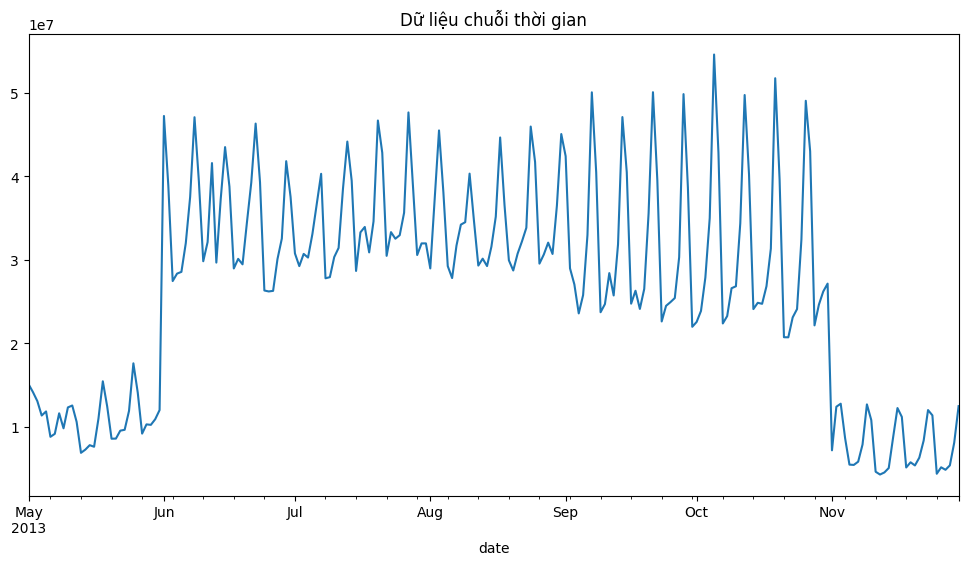

In [44]:
# Trực quan hóa dữ liệu
df['truong_3'].plot(figsize=(12, 6))
plt.title('Dữ liệu chuỗi thời gian')
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [47]:
# Lọc dữ liệu cho tháng 11
df_november = df[df.index.month == 11]

# Kiểm tra dữ liệu sau khi lọc
print(df_november.head())
print(f"Số lượng mẫu dữ liệu trong tháng 11: {len(df_november)}")

# Chọn cột chuỗi thời gian mục tiêu và các biến giải thích nếu có
y = df_november[['truong_3']]
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

# Chuyển đổi lại dữ liệu đã chuẩn hóa thành DataFrame để dễ thao tác
y_scaled = pd.DataFrame(y_scaled, index=y.index, columns=['truong_3'])

            truong_1  truong_2  truong_3       truong_4  truong_5
date                                                             
2013-11-01      6570     19735   7154827  624958.666667       963
2013-11-02     10980     32521  12377632  886742.479167      1617
2013-11-03     11710     34610  12740354  901589.962500      1765
2013-11-04      7800     22827   8629941  632386.508333      1143
2013-11-05      5310     15769   5441257  454998.713889       947
Số lượng mẫu dữ liệu trong tháng 11: 30


ADF Statistic: -3.797868
p-value: 0.002929
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


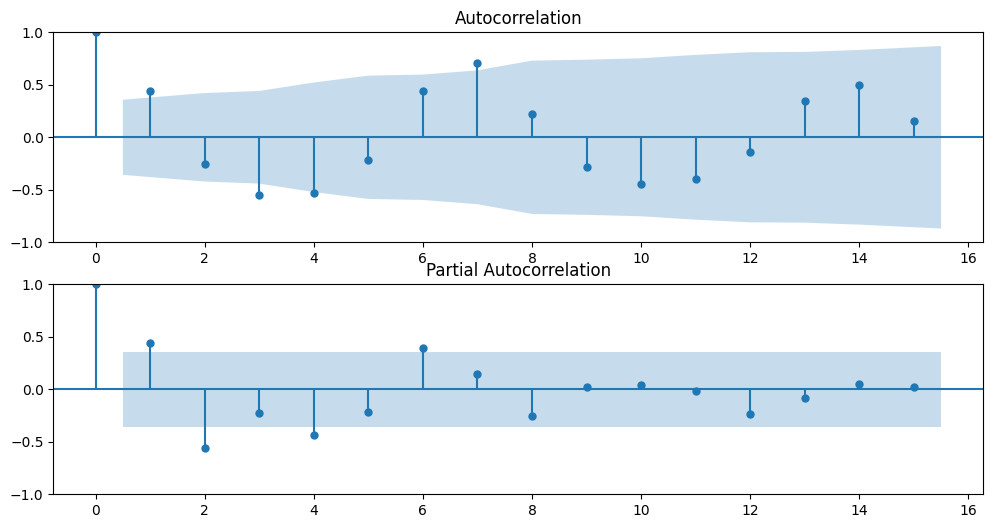

In [48]:
# Kiểm tra tính tĩnh bằng ADF
result = adfuller(y_scaled['truong_3'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Vẽ đồ thị ACF và PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(y_scaled, ax=plt.gca())
plt.subplot(212)
plot_pacf(y_scaled, ax=plt.gca())
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                           truong_3   No. Observations:                   30
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -29.672
Date:                            Tue, 04 Jun 2024   AIC                             69.345
Time:                                    04:36:54   BIC                             73.511
Sample:                                11-01-2013   HQIC                            69.759
                                     - 11-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0266      0.518      0.051      0.959      -0.989       1.043
ma.L1          0.6429      0.577   

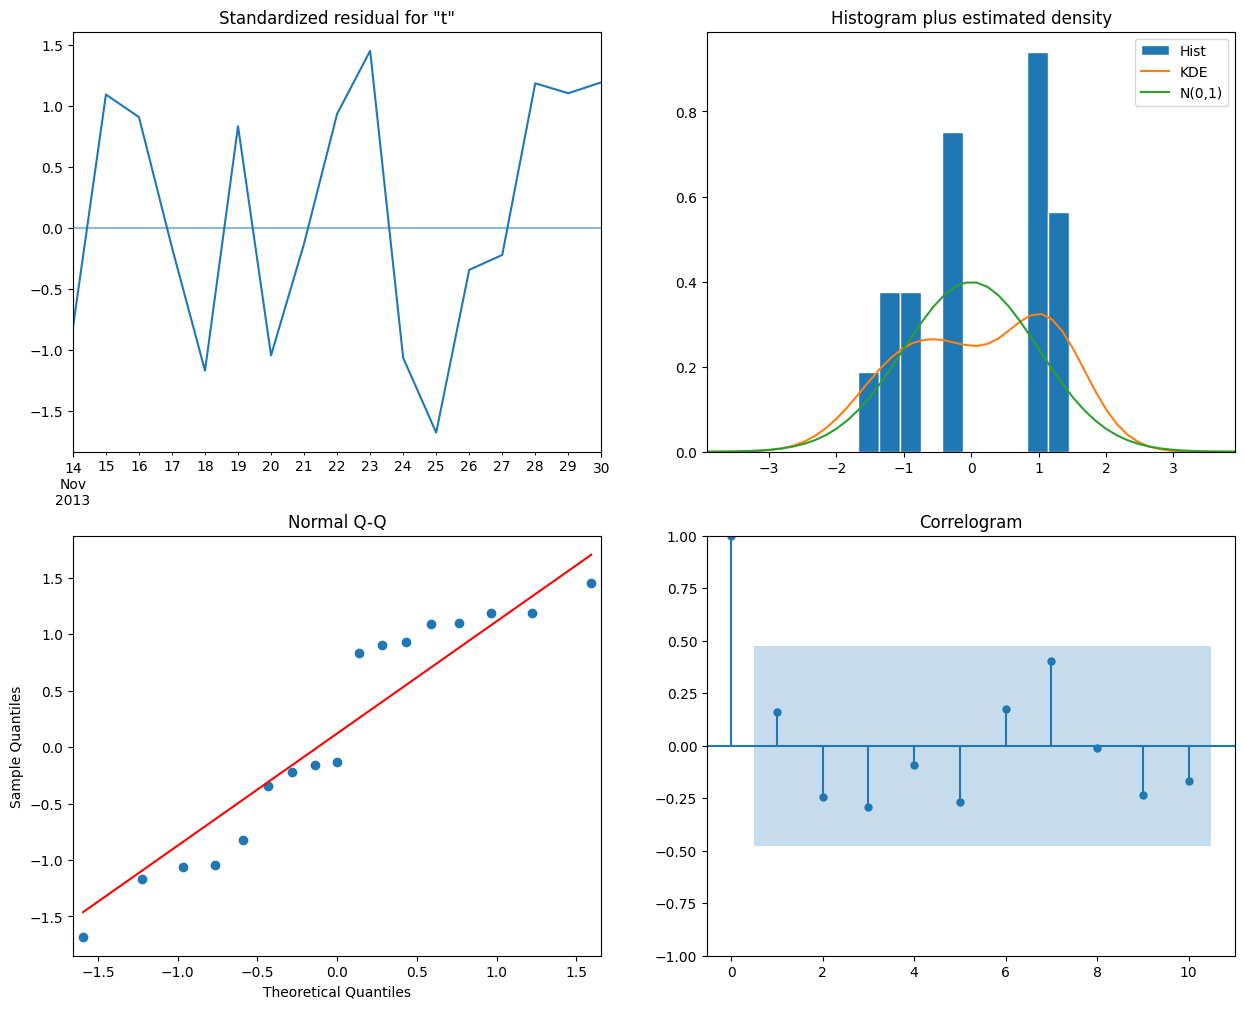

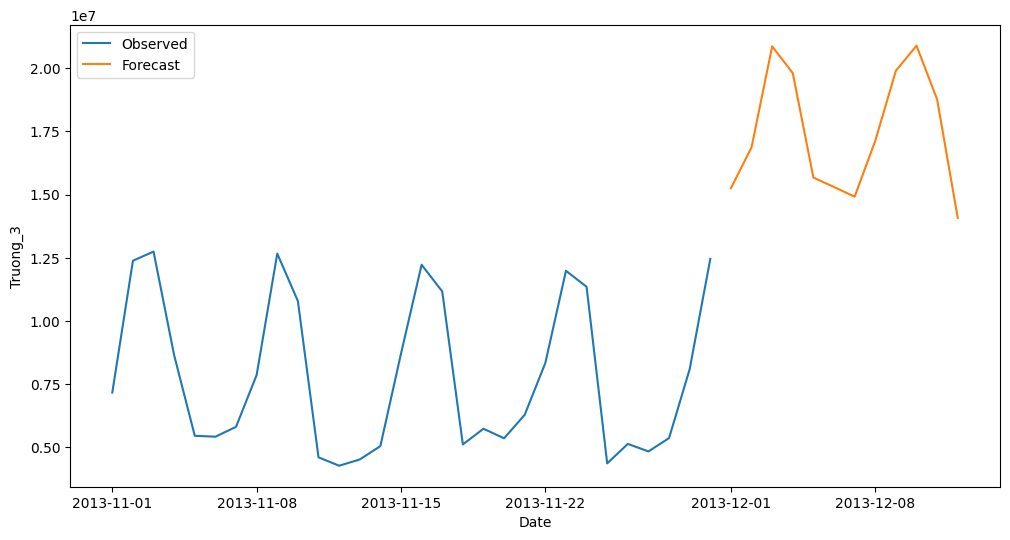

In [49]:
# Xây dựng và huấn luyện mô hình SARIMA
# Tham số order và seasonal_order có thể được điều chỉnh dựa trên ACF và PACF
model = SARIMAX(y_scaled, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Hiển thị kết quả mô hình
print(results.summary())

# Chẩn đoán mô hình
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Dự báo
forecast_scaled = results.get_forecast(steps=12)
forecast_mean_scaled = forecast_scaled.predicted_mean
forecast_conf_int_scaled = forecast_scaled.conf_int()

# Chuyển đổi dự báo về lại đơn vị gốc
forecast_mean = scaler.inverse_transform(forecast_mean_scaled.values.reshape(-1, 1))
forecast_conf_int = scaler.inverse_transform(forecast_conf_int_scaled)

# Chuyển đổi lại DataFrame để vẽ đồ thị
forecast_mean = pd.Series(forecast_mean.flatten(), index=forecast_mean_scaled.index)
forecast_conf_int = pd.DataFrame(forecast_conf_int, index=forecast_conf_int_scaled.index, columns=['lower truong_3', 'upper truong_3'])

# Vẽ đồ thị dự báo
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed')
plt.plot(forecast_mean, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Truong_3')
plt.legend()
plt.show()

In [55]:
# Chọn biến mục tiêu
y = df_november['truong_3']

# Chuẩn hóa dữ liệu nếu cần
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Xây dựng DataFrame mới chỉ với biến mục tiêu đã chuẩn hóa
df_arimax = pd.DataFrame({
    'truong_3': y_scaled.flatten(),
    'truong_1': X_scaled[:, 0],
    'truong_5': X_scaled[:, 1]
})

# Xây dựng và huấn luyện mô hình SARIMAX với biến giải thích
model_arimax = SARIMAX(df_arimax['truong_3'], exog=df_arimax[['truong_1', 'truong_5']],
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_arimax = model_arimax.fit()

# Hiển thị kết quả mô hình ARIMAX
print(results_arimax.summary())




                                     SARIMAX Results                                      
Dep. Variable:                           truong_3   No. Observations:                   30
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  13.046
Date:                            Tue, 04 Jun 2024   AIC                            -12.092
Time:                                    04:44:49   BIC                             -6.260
Sample:                                         0   HQIC                           -11.512
                                             - 30                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
truong_1       1.0212      0.126      8.111      0.000       0.774       1.268
truong_5      -0.0386      0.123   

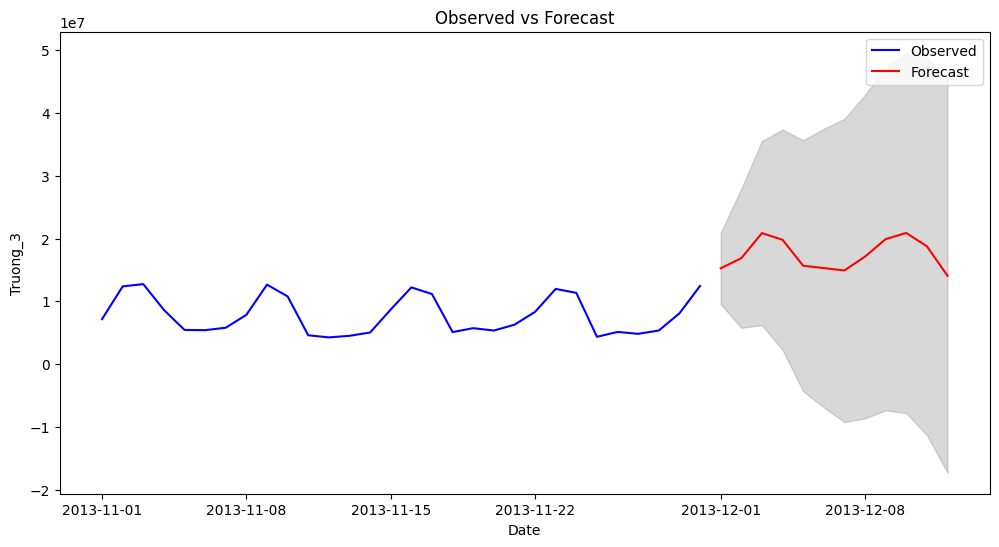

In [57]:
# Vẽ biểu đồ giữa giá trị thực tế và dự đoán
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu thực tế
plt.plot(y.index, y, label='Observed', color='blue')

# Vẽ dữ liệu dự đoán
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Vẽ khoảng tin cậy cho dự đoán
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)

# Đặt nhãn và tiêu đề cho biểu đồ
plt.xlabel('Date')
plt.ylabel('Truong_3')
plt.title('Observed vs Forecast')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()
